In [1]:
import sqlite3
import pandas as pd

# CSV 文件路径
csv_file = r"C:\Users\Administrator\Desktop\simple eda\simple eda\EDA\prefectlearning\data\output\final\84wall.csv"

# 读取 CSV 为 DataFrame
df = pd.read_csv(csv_file)

# 创建 SQLite 连接（数据库保存到 C:\sqlite3\mydata.db）
conn = sqlite3.connect(r"C:\sqlite3\mydata.db")

# 导入到名为 mytable 的表中（如果有就替换）
df.to_sql("games", conn, if_exists="replace", index=False)

conn.close()

print("✅ 成功导入到 mydata.db 中的 mytable 表！")


C:\Users\Administrator\AppData\Local\Temp\ipykernel_35408\934407906.py:8: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)


✅ 成功导入到 mydata.db 中的 mytable 表！


In [2]:
csv_file = r"C:/Users/Administrator/Desktop/simple eda/simple eda/EDA/prefectlearning/models/player84w.csv"

# 读取 CSV 为 DataFrame
df = pd.read_csv(csv_file)

# 创建 SQLite 连接（数据库保存到 C:\sqlite3\mydata.db）
conn = sqlite3.connect(r"C:\sqlite3\mydata.db")

# 导入到名为 mytable 的表中（如果有就替换）
df.to_sql("players", conn, if_exists="replace", index=False)

conn.close()

print("✅ 成功导入到 mydata.db 中的 mytable 表！")


✅ 成功导入到 mydata.db 中的 mytable 表！


for winning style
purpose:
1.relationships between elo&win_rate
2.is better at black/white? compare:win as black&win as white

for clean data type,didnt exclude the very short games

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [4]:
conn=sqlite3.connect(r"C:\sqlite3\mydata.db")
df_players = pd.read_sql_query("SELECT * FROM players", conn)
conn.close()
print(df_players.head())

                   user  white_games  black_games  total_games  wins_white  \
0      Zhigalko, Sergei         1048         1007         2055       708.0   
1       Mikhail_Golubev         1014         1020         2034       522.0   
2          Kamsky, Gata          974          994         1968       625.0   
3  FairChess_on_YouTube          989          953         1942       714.0   
4     Bortnyk, Olexandr          964          919         1883       685.0   

   wins_black  wins_total  draw_white  draw_black  draw_total  ...  \
0       602.0      1310.0       113.0       114.0       227.0  ...   
1       478.0      1000.0        87.0        93.0       180.0  ...   
2       533.0      1158.0       207.0       242.0       449.0  ...   
3       605.0      1319.0       150.0       187.0       337.0  ...   
4       612.0      1297.0       100.0        98.0       198.0  ...   

   accuracy_opening  accuracy_middlegame  accuracy_endgame  win_rate  \
0         96.731866            92.6509

In [5]:
#clean games are terminated by accient
#如果不删掉，线性回归的result就不会有具体数字
df_players = df_players.dropna(subset=["elo", "win_rate"])

LinregressResult(slope=np.float64(0.0003471824322687337), intercept=np.float64(-0.3982098834765903), rvalue=np.float64(0.6547967405755437), pvalue=np.float64(0.0), stderr=np.float64(3.6741808302687157e-06), intercept_stderr=np.float64(0.00882044055140904))


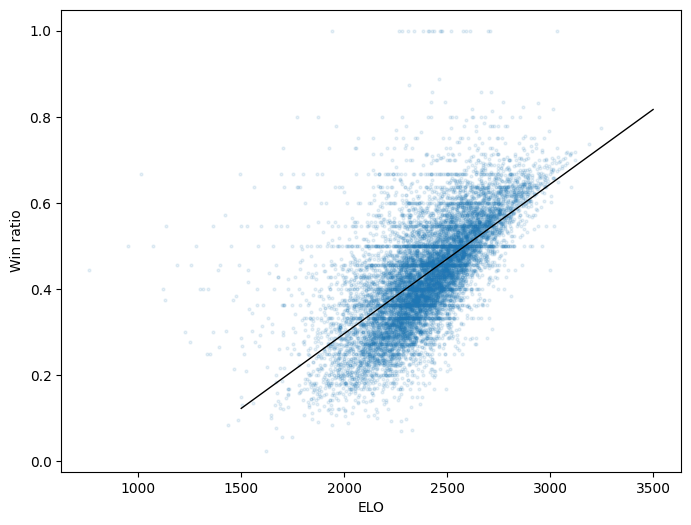

In [6]:
plt.figure(figsize=(8,6))
plt.plot(df_players.elo, df_players.win_rate, 'o', alpha=0.1, ms=2)
elo_range = np.linspace(1500,3500, 10)
result = linregress(df_players.elo, df_players.win_rate)
plt.ylabel('Win ratio')
plt.xlabel('ELO')
plt.plot(elo_range, result.slope*elo_range + result.intercept, 'k-', lw=1)
print(result)

The linear regression result appears to be of limited significance, as the data points are overly dense and form a cluster, making it difficult to capture a meaningful linear trend.

In [7]:
df_roles=pd.DataFrame()
df_roles['Player']=df_players['user']
df_roles['ELO']=df_players['elo']
df_roles['wins_white_ratio']=df_players['wins_white']/df_players['white_games']
df_roles['wins_black_ratio']=df_players['wins_black']/df_players['black_games']
df_roles['total_games']=df_players['white_games']+df_players['black_games']
df_roles['white_weights']=df_players['white_games']/(df_players['white_games']+df_players['black_games'])
df_roles['black_weights']=df_players['black_games']/(df_players['white_games']+df_players['black_games'])
df_roles['diff_weighted']=df_roles['wins_white_ratio']*df_roles['white_weights']-df_roles['wins_black_ratio']*df_roles['black_weights']
conn = sqlite3.connect(r"C:\sqlite3\mydata.db")
df_roles.to_sql("roles", conn, if_exists="replace", index=False)
conn.close()
df_roles.head()

,Player,ELO,wins_white_ratio,wins_black_ratio,total_games,white_weights,black_weights,diff_weighted
0,"Zhigalko, Sergei",2698.362333,0.675573,0.597815,2055,0.509976,0.490024,0.051582
1,Mikhail_Golubev,2578.552541,0.514793,0.468627,2034,0.498525,0.501475,0.021632
2,"Kamsky, Gata",2702.934469,0.641684,0.536217,1968,0.494919,0.505081,0.046748
3,FairChess_on_YouTube,3015.144404,0.721941,0.634837,1942,0.509269,0.490731,0.056128
4,"Bortnyk, Olexandr",2766.626003,0.710581,0.665941,1883,0.511949,0.488051,0.038768


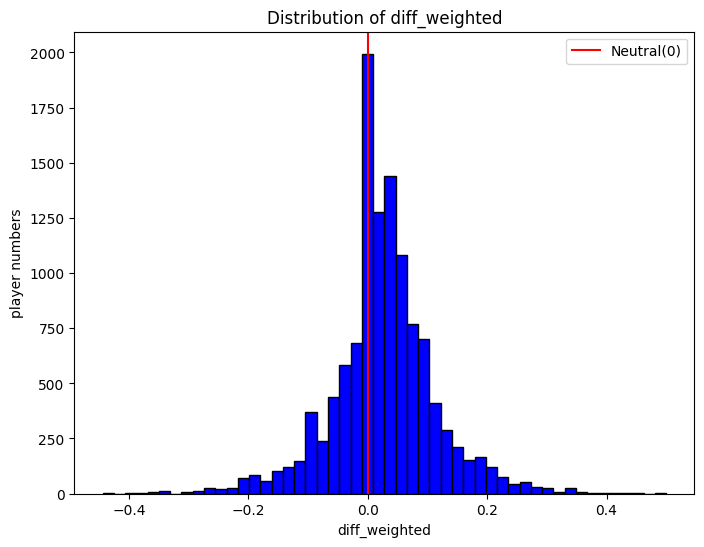

In [8]:
plt.figure(figsize=(8,6))
plt.hist(df_roles['diff_weighted'],bins=50,color='blue',edgecolor='black')
plt.axvline(0,color='red',label='Neutral(0)')
plt.title('Distribution of diff_weighted')
plt.xlabel('diff_weighted')
plt.ylabel('player numbers')
plt.legend()
#plt.grid(True)
plt.show()

more people are more good at WHITE    
(maybe because the First-Move-Advantage?)    
"Opening preparation: The majority of chess opening theory is built from White's perspective. Players often study aggressive White openings more thoroughly than defensive Black responses."

A:good as white     
B:good as black      
C:good as both     
question: are the top players good at both?

In [9]:
def classify_player_roles(diff_weighted):
    if diff_weighted>0.07:
        return "White"
    if diff_weighted<-0.07:
        return "Black"
    else:
        return "Both"
df_roles['B/W_type'] = df_roles['diff_weighted'].apply(classify_player_roles)

In [10]:
conn = sqlite3.connect(r"C:\sqlite3\mydata.db")
df_roles.to_sql("roles", conn, if_exists="replace", index=False)
conn.close()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_35408\1852597029.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


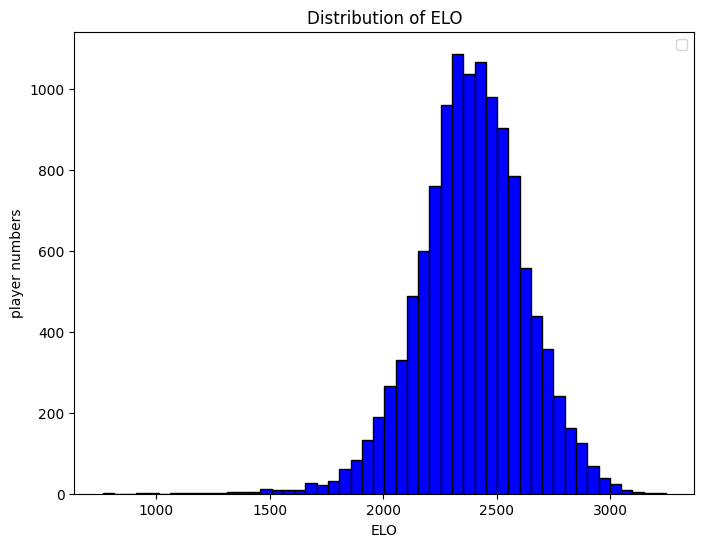

In [11]:
#see the top players:
plt.figure(figsize=(8,6))
plt.hist(df_roles['ELO'],bins=50,color='blue',edgecolor='black')
plt.title('Distribution of ELO')
plt.xlabel('ELO')
plt.ylabel('player numbers')
plt.legend()
#plt.grid(True)
plt.show()

In [12]:
print(df['elo'].describe())

count    11898.000000
mean      2389.026151
std        236.015089
min        763.000000
25%       2249.032960
50%       2392.835256
75%       2541.344035
max       3246.753311
Name: elo, dtype: float64


In [13]:
q95 = df_players['elo'].quantile(0.95)
print("95% 分位数 ELO 值为：", q95)
q75=df_players['elo'].quantile(0.50)
print("75% 分位数 ELO 值为：", q75)
q25=df_players['elo'].quantile(0.25)
print("25% 分位数 ELO 值为：", q25)

def classify_elo_detailed(elo):
    if elo >q95:
        return "GrandMaster"
    elif elo >= q75:
        return "HighLevel"
    elif elo >= q25:
        return "InterMediate"
    else:
        return "EntryLevel"
df_roles['Group'] = df_roles['ELO'].apply(classify_elo_detailed)

95% 分位数 ELO 值为： 2763.518984962406
75% 分位数 ELO 值为： 2392.835256410256
25% 分位数 ELO 值为： 2249.032960255825


In [14]:
conn = sqlite3.connect(r"C:\sqlite3\mydata.db")
df_roles.to_sql("roles", conn, if_exists="replace", index=False)
conn.close()

In [15]:
def role_distribution(df,group_col='Group',role_col='B/W_type'):
    order=["GrandMaster",'HighLevel','InterMediate','EntryLevel']
    df[group_col]=pd.Categorical(df[group_col],categories=order,ordered=True)
    result=(
        df.groupby(group_col)[role_col]
        .value_counts(normalize=True)
        .rename('ratio')
    )

    return result
role_result=role_distribution(df_roles)
role_result

C:\Users\Administrator\AppData\Local\Temp\ipykernel_35408\2120519406.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(group_col)[role_col]


Group         B/W_type
GrandMaster   Both        0.680672
              White       0.242017
              Black       0.077311
HighLevel     Both        0.643818
              White       0.255883
              Black       0.100299
InterMediate  Both        0.645259
              White       0.232683
              Black       0.122058
EntryLevel    Both        0.663193
              White       0.225882
              Black       0.110924
Name: ratio, dtype: float64

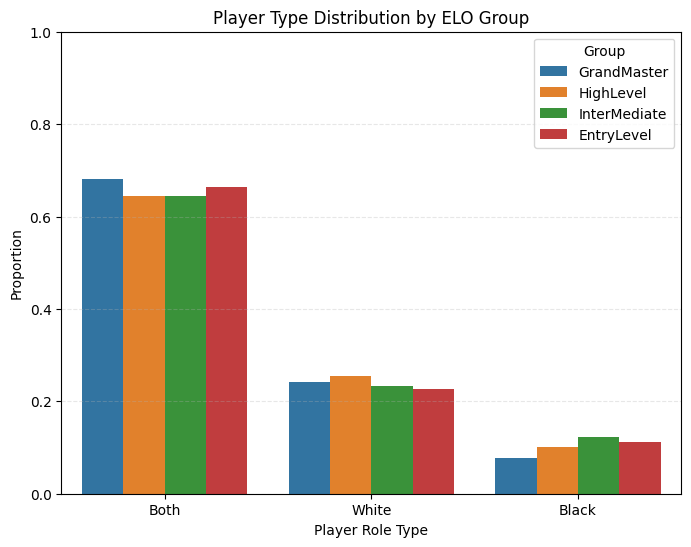

In [16]:
df_plot = role_result.reset_index()
plt.figure(figsize=(8,6))
sns.barplot(
    data=df_plot,
    x='B/W_type',     # 分三大类：White, Black, Both
    y='ratio',        # 比例
    hue='Group',      # 用 Group 分颜色
    hue_order=["GrandMaster",'HighLevel','InterMediate','EntryLevel'],  
)
plt.title("Player Type Distribution by ELO Group")
plt.ylabel("Proportion")
plt.xlabel("Player Role Type")
plt.legend(title="Group")
plt.ylim(0, 1)
plt.grid(True, axis='y', linestyle='--', alpha=0.3)
plt.show()

We might expect that stronger players are more balanced and less influenced by the first-move advantage.   
  
I can understand why tail players are also likely to be classified as "Both" — perhaps because they lose most of the time, making it hard to show a clear strength with either color.   

The classification threshold in the classify_player_roles function is set to 0.07.

winning style

# K-means

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import xlrd
from sklearn import preprocessing
from mpl_toolkits.mplot3d import Axes3D
from xlsxwriter import worksheet
import sqlite3
import csv
import numpy as np
from sklearn import preprocessing
import plotly.express as px
import plotly.io as pio
import cursor
import csv
from prefect import flow, task


cluster players based on these three-dimensional features(accuracy_opening, accuracy_middlegame, and accuracy_endgame) to see if there are distinct types (e.g., strong in openings but weak in endgames).   
First standardize three features (using z-score or MinMax), then apply KMeans clustering with the default Euclidean distance.   
Since the three features are similar in meaning (all representing accuracy), Euclidean distance after standardization can reasonably reflect the differences between players.



In [18]:
def normalize(X,axis=-1,p=2):
    lp_norm=np.atleast_1d(np.linalg.norm(X,p,axis))
    lp_norm[lp_norm==0]=1 #把范数为 0 的项改成 1，确保后续归一化不会产生无穷或 NaN
    return X/np.expand_dims(lp_norm,axis)

def euclidean_distance(one_sample,X):
    one_sample=one_sample.reshape(1,-1) #将one_sample变为二维（1行，若干列）
    X=X.reshape(X.shape[0],-1) #X为二维矩阵，有X.shape[0]行，1列。每一行代表一个样本向量
    distances=np.power(np.tile(one_sample,(X.shape[0],1))-X,2).sum(axis=1) #one_sample与X中每个样本距离平方的数组
    return distances #是欧式距离的平方

one_sample=np.array([1,2])   
X=np.array([[1,2],[2,2],[1,3]])   
则输出会是(0+(1-2)^2+(2-3)^2)^2   

解析：   
执行完one_sample=one_sample.reshape(1,-1)后，one_sample=[[1,2]]   shape:(1,2)   
执行完X=X.reshape(X.shape[0],-1)后，X的shape(3,2)   
np.title(one_sample,(X.shape[0],1)):把one_sample复制为3行，   
即：[[1,2],   
     [1,2],   
     [1,2]]      
再与X相减，每一行和X的对应行做差：   
得到[[0,0],    
[-1,0],   
[0,-1]]   
np.title(...,2)为将每个元素平方：    
[[0,0],   
[1,0],   
[0,1]]    
最后.sum(axis=1)为每行求和得到      
[0,1,1]

In [19]:
class Kmeans():
    """_summary_
    """    
    def __init__(self,k=4,max_iterations=500,varepsilon=0.0001):
        self.k=k
        self.max_iterations=max_iterations
        self.varepsilon=varepsilon

    def init_random_centroids(self,X):
        n_samples,n_features=np.shape(X)
        centroids=np.zeros((self.k,n_features))
        for i in range(self.k):
            centroid=X[np.random.choice(range(n_samples))]
            centroids[i]=centroid
        return centroids
    
    def closest_centroid(self,sample,centroids):
        distances=euclidean_distance(sample,centroids)
        closest_i=np.argmin(distances)
        return closest_i
    
    def create_clusters(self,centroids,X):
        n_samples=np.shape(X)[0]
        clusters=[[] for _ in range(self.k)]
        for sample_i,sample in enumerate(X):
            centroid_i=self.closest_centroid(sample,centroids)
            clusters[centroid_i].append(sample_i)
        return clusters
    
    def update_centroids(self,clusters,X):
        n_features=np.shape(X)[1]
        centroids=np.zeros((self.k,n_features))
        for i, cluster in enumerate(clusters):
            centroid = np.mean(X[cluster], axis=0)
            centroids[i] = centroid
        return centroids
    
    def get_cluster_labels(self, clusters, X):
        y_pred = np.zeros(np.shape(X)[0])
        for cluster_i, cluster in enumerate(clusters):
            for sample_i in cluster:
                y_pred[sample_i] = cluster_i
        return y_pred
    
    def predict(self, X):
        # 从所有样本中随机选取self.k样本作为初始的聚类中心
        centroids = self.init_random_centroids(X)

        # 迭代，直到算法收敛(上一次的聚类中心和这一次的聚类中心几乎重合)或者达到最大迭代次数
        for _ in range(self.max_iterations):
            # 将所有进行归类，归类规则就是将该样本归类到与其最近的中心
            clusters = self.create_clusters(centroids, X)
            former_centroids = centroids

            # 计算新的聚类中心
            centroids = self.update_centroids(clusters, X)

            # 如果聚类中心几乎没有变化，说明算法已经收敛，退出迭代
            diff = centroids - former_centroids
            if diff.any() < self.varepsilon:
                break

        return self.get_cluster_labels(clusters, X)

[2. 2. 2. ... 0. 2. 2.]


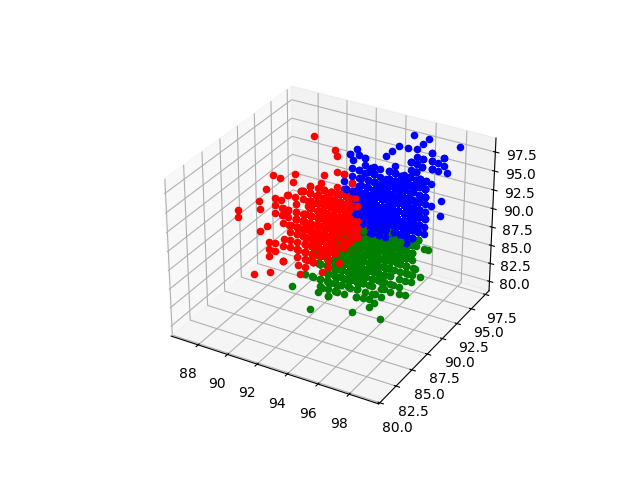

In [20]:

%matplotlib widget

conn =sqlite3.connect(r"C:\sqlite3\mydata.db")
cursor=conn.cursor()
cursor.execute("SELECT accuracy_opening, accuracy_middlegame, accuracy_endgame FROM players")
rows = cursor.fetchall()
data = [list(row) for row in rows if None not in row]
cursor.close()
conn.close()

min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
A = np.array(data)
X=min_max_scaler.fit_transform(A)
num, dim = X.shape
clf = Kmeans(k=3)
y_pred = clf.predict(X)
print(y_pred)
color = ['r', 'g', 'b', 'c', 'y', 'm', 'k']
ax = plt.subplot(111, projection='3d')
f = open('C:\\Users\\Administrator\\Desktop\\simple eda\\simple eda\\EDA\\analysis\\stageresults.csv', 'w', encoding='utf-8', newline='')
csv_writer = csv.writer(f)

for p in range(0,num):
    y=y_pred[p]
    csv_writer.writerow([y])
    ax.scatter(int(A[p, 0]), int(A[p, 1]), int(A[p, 2]), c=color[int(y)])
f.close()
plt.show()

In [21]:
# 读取数据库
conn = sqlite3.connect(r"C:\sqlite3\mydata.db")
cursor = conn.cursor()

cursor.execute("SELECT user, accuracy_opening, accuracy_middlegame, accuracy_endgame FROM players")
rows = cursor.fetchall()

names = []
data = []
# 数据清洗
for row in rows:
    if None not in row:  # 确保数据完整
        names.append(row[0])         # user 名字
        data.append(list(row[1:]))   # 只取数值列

# 归一化
A = np.array(data, dtype=float)
X = preprocessing.MinMaxScaler().fit_transform(A)
num, dim = X.shape

# 聚类
clf = KMeans(n_clusters=3)
y_pred = clf.fit_predict(X)

# 更新数据库写入聚类结果
conn = sqlite3.connect(r"C:\sqlite3\mydata.db")
cursor = conn.cursor()
try:
    cursor.execute("ALTER TABLE roles ADD COLUMN stages INTEGER")
except sqlite3.OperationalError:
    print("Column 'stages' already exists.")
conn.commit()
for Player, cluster_label in zip(names, y_pred):
    cursor.execute("UPDATE roles SET stages=? WHERE Player=?", (int(cluster_label), Player))
conn.commit()
cursor.close()
conn.close()

# 保存聚类结果到 CSV
with open(r'C:\Users\Administrator\Desktop\simple eda\simple eda\EDA\analysis\stageresults.csv', 'w', encoding='utf-8', newline='') as f:
    writer = csv.writer(f)
    for y in y_pred:
        writer.writerow([y])

# 构造 Plotly 图
fig = px.scatter_3d(
    x=A[:, 0],
    y=A[:, 1],
    z=A[:, 2],
    color=[str(label) for label in y_pred],  # 转为字符串分类
    labels={'x': 'Opening', 'y': 'Middlegame', 'z': 'Endgame'},
    title='KMeans Clustering of Player Accuracy'
)

# 导出 HTML 网页
fig.write_html("graph.html")

# 可选：在 notebook 中预览
# fig.show()

In [23]:
# 任务1：读取数据库数据
@task
def load_data(db_path):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    cursor.execute("SELECT user, accuracy_opening, accuracy_middlegame, accuracy_endgame FROM players")
    rows = cursor.fetchall()
    cursor.close()
    conn.close()
    
    names = []
    data = []
    for row in rows:
        if None not in row:
            names.append(row[0])
            data.append(list(row[1:]))
    return names, np.array(data, dtype=float)

# 任务2：归一化
@task
def normalize_data(data):
    return preprocessing.MinMaxScaler().fit_transform(data)

# 任务3：聚类
@task
def cluster_data(X, k=3):
    clf = Kmeans(k=k)
    labels = clf.predict(X)
    return labels

# 任务4：更新数据库
@task
def update_database(db_path, names, labels):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    try:
        cursor.execute("ALTER TABLE roles ADD COLUMN stages INTEGER")
    except sqlite3.OperationalError:
        pass  # 字段已存在
    
    for user, label in zip(names, labels):
        cursor.execute("UPDATE roles SET stages=? WHERE Player=?", (int(label), user))
    conn.commit()
    cursor.close()
    conn.close()

# 任务5：保存CSV
@task
def save_csv(labels, csv_path):
    with open(csv_path, 'w', encoding='utf-8', newline='') as f:
        writer = csv.writer(f)
        for label in labels:
            writer.writerow([label])

# 任务6：绘图并导出HTML
@task
def plot_and_save_html(X, labels, html_path):
    fig = px.scatter_3d(
        x=X[:, 0], y=X[:, 1], z=X[:, 2],
        color=[str(label) for label in labels],
        labels={'x': 'Opening', 'y': 'Middlegame', 'z': 'Endgame'},
        title='KMeans Clustering of Player Accuracy'
    )
    fig.write_html(html_path)

# 主流程
@flow
def clustering_pipeline():
    db_path = r"C:\sqlite3\mydata.db"
    csv_path = r"C:\Users\Administrator\Desktop\simple eda\simple eda\EDA\analysis\stageresults.csv"
    html_path = "graph.html"

    names, data = load_data(db_path)
    X = normalize_data(data)
    labels = cluster_data(X, k=3)
    update_database(db_path, names, labels)
    save_csv(labels, csv_path)
    plot_and_save_html(X, labels, html_path)

if __name__ == "__main__":
    clustering_pipeline()

19:58:59.952 | INFO    | Flow run 'just-toad' - Beginning flow run 'just-toad' for flow 'clustering-pipeline'

19:58:59.953 | INFO    | Flow run 'just-toad' - View at https://app.prefect.cloud/account/71508390-397c-440e-97b4-78dbc476dcb7/workspace/172b3720-fac9-4160-bb30-ce47604ed31d/runs/flow-run/0687b888-3802-7dd0-8000-b0f9260ba5a7

19:59:00.112 | INFO    | Task run 'load_data-35b' - Finished in state Completed()

19:59:00.257 | INFO    | Task run 'normalize_data-f3b' - Finished in state Completed()

19:59:03.283 | INFO    | Task run 'cluster_data-2c9' - Finished in state Completed()

19:59:08.291 | INFO    | Task run 'update_database-610' - Finished in state Completed()

19:59:08.440 | INFO    | Task run 'save_csv-b32' - Finished in state Completed()

19:59:08.623 | INFO    | Task run 'plot_and_save_html-2f6' - Finished in state Completed()

19:59:08.970 | INFO    | Flow run 'just-toad' - Finished in state Completed()

# GMM

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

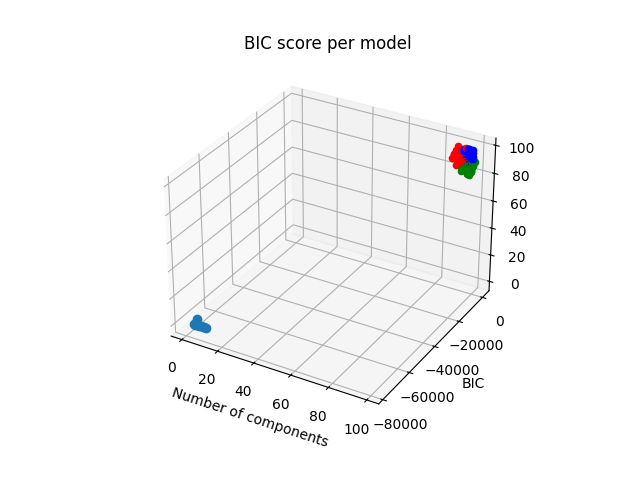

In [ ]:
import sqlite3
import numpy as np
import csv
from sklearn import preprocessing
from sklearn.mixture import GaussianMixture
import plotly.express as px

# 读取数据库
conn = sqlite3.connect(r"C:\sqlite3\mydata.db")
cursor = conn.cursor()

cursor.execute("SELECT user, accuracy_opening, accuracy_middlegame, accuracy_endgame FROM players")
rows = cursor.fetchall()

names = []
data = []
for row in rows:
    if None not in row:
        names.append(row[0])
        data.append(list(row[1:]))

# 归一化
A = np.array(data, dtype=float)
X = preprocessing.MinMaxScaler().fit_transform(A)

# 使用 GMM 聚类
lowest_bic = np.inf
bic = []
n_components_range = range(1, 10)
best_gmm = None

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(X)
    curr_bic = gmm.bic(X)
    bic.append(curr_bic)
    if curr_bic < lowest_bic:
        lowest_bic = curr_bic
        best_gmm = gmm

# 绘制 BIC 图（可选）
plt.plot(n_components_range, bic, marker='o')
plt.xlabel('Number of components')
plt.ylabel('BIC')
plt.title('BIC score per model')
plt.grid(True)
plt.show()

# 使用最优模型预测
y_pred = best_gmm.predict(X)


# 更新数据库写入聚类结果
conn = sqlite3.connect(r"C:\sqlite3\mydata.db")
cursor = conn.cursor()
try:
    cursor.execute("ALTER TABLE roles ADD COLUMN stages_gmm INTEGER")
except sqlite3.OperationalError:
    print("Column 'stages_gmm' already exists.")
conn.commit()

for Player, cluster_label in zip(names, y_pred):
    cursor.execute("UPDATE roles SET stages_gmm=? WHERE Player=?", (int(cluster_label), Player))
conn.commit()
cursor.close()
conn.close()

# 保存聚类结果到 CSV
with open(r'C:\Users\Administrator\Desktop\simple eda\simple eda\EDA\analysis\gmm_stageresults.csv', 'w', encoding='utf-8', newline='') as f:
    writer = csv.writer(f)
    for y in y_pred:
        writer.writerow([y])

# 构造 Plotly 图
fig = px.scatter_3d(
    x=A[:, 0],
    y=A[:, 1],
    z=A[:, 2],
    color=[str(label) for label in y_pred],
    labels={'x': 'Opening', 'y': 'Middlegame', 'z': 'Endgame'},
    title='GMM Clustering of Player Accuracy'
)

fig.write_html("graph_gmm.html")
